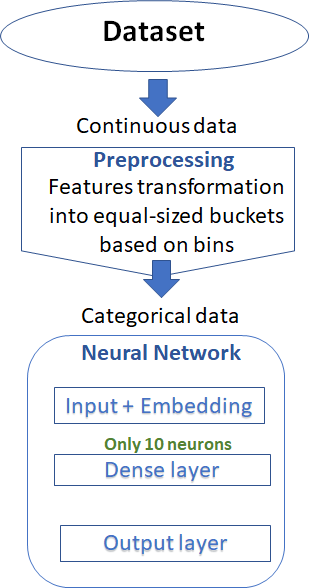

In [ ]:
from sklearn.model_selection import KFold,StratifiedKFold
from sklearn.preprocessing import StandardScaler,MinMaxScaler
from sklearn.metrics import mean_squared_error

import numpy as np 
import pandas as pd
import math

import tensorflow as tf
import tensorflow.keras.backend as K
import tensorflow_addons as tfa
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras import activations,callbacks
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import initializers
from tensorflow.keras import regularizers
from keras.models import Model

In [ ]:
train = pd.read_csv('../input/tabular-playground-series-aug-2021/train.csv')
test = pd.read_csv("../input/tabular-playground-series-aug-2021/test.csv")
sample_submission = pd.read_csv("../input/tabular-playground-series-aug-2021/sample_submission.csv")


In [ ]:
y = train['loss']
X = train.drop(['id','loss'],axis = 1)
test = test.drop(['id'],axis = 1)
y.shape,X.shape,test.shape

In [ ]:
# Preprocessing :
df0 = np.zeros((400000,100))
df = pd.concat([X,test],axis=0,copy=False)
for i in range(X.shape[1]):
    df0[:,i] = pd.qcut(df.iloc[:,i],50,labels=False,duplicates = 'drop').values
X_q = df0[:X.shape[0],:]
test_q = df0[X.shape[0]:,:]
X_q.shape,test_q.shape

In [ ]:

es = tf.keras.callbacks.EarlyStopping(
    monitor= 'val_loss', min_delta=1e-15, patience=10, verbose=0,
    mode='auto', baseline=None, restore_best_weights=True)

plateau = tf.keras.callbacks.ReduceLROnPlateau(
    monitor='val_loss', factor=0.8, patience=3, verbose=0,
    mode='auto')

In [ ]:
def emb_model():
    
    # Input & embedding/conv layer :
    
    emb_inputs = layers.Input(shape = (100))
    x = layers.Embedding (input_dim = 50, output_dim = 10)(emb_inputs)
    x = layers.Conv1D(10,1,activation = 'relu')(x)
    x = layers.Flatten()(x)
    x = layers.Dropout(0.3)(x)
    
    # only one Dense layer :

    x = layers.Dense(
            units = 10, 
            activation ='relu',
            kernel_initializer ='he_uniform')(x)
    
    # Output layer :
    
    emb_outputs = layers.Dense(
        units = 1,
        activation = 'linear',
        kernel_initializer ='he_uniform',name = 'last')(x)

    #----------- Model instantiation  ---------------
    model = Model(emb_inputs,emb_outputs)

    return model

In [ ]:
N_FOLDS = 10
SEED = 42
EPOCH = 50
N_round = 1

for i in range (N_round):
    
    oof = np.zeros((X_q.shape[0],1))
    pred = np.zeros((test_q.shape[0],1))

    skf = StratifiedKFold(n_splits=N_FOLDS, 
                          shuffle=True, 
                          random_state=SEED *i
                         )

    for fold, (tr_idx, ts_idx) in enumerate(skf.split(X_q,y)):
        print(f"\n ====== TRAINING ROUND {i} FOLD {fold} =======\n")

        X_train = X_q[tr_idx]
        y_train = y[tr_idx]
        X_test = X_q[ts_idx]
        y_test = y[ts_idx]

        K.clear_session()

        #================= MODEL training =========

        model= emb_model()
        model.compile(loss='mse',metrics=[tf.keras.metrics.RootMeanSquaredError()],optimizer = keras.optimizers.Adam(learning_rate=0.001))
        #model.compile(loss=error,optimizer = keras.optimizers.Adam(learning_rate=0.01))
        model.fit(X_train, y_train,
                  batch_size = 128, 
                  epochs = EPOCH,
                  validation_data=(X_test, y_test),
                  callbacks=[es, plateau],
                  verbose = 0)

        #============== Model prediction ==========

        pred_round = model.predict(X_test) 
        oof[ts_idx] += pred_round
        score_NN_round = math.sqrt(mean_squared_error(y_test, pred_round))
        print(f"\nFOLD {fold} round {i} Score regression model: {score_NN_round}\n")
        pred += model.predict(test_q) / N_FOLDS 
     

    score_round = math.sqrt(mean_squared_error(y, oof))
    print(f"\n=== FINAL SCORE round {i} REGRESSION MODEL  : {score_round}===\n") 

In [ ]:
sample_submission['loss'] = pred

In [ ]:
sample_submission.to_csv('submission9.csv',index = False)
display(pd.read_csv("submission9.csv"))